<a href="https://colab.research.google.com/github/eunhwa99/DeepLearning/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl

#matplotlib.pylab의 rcParams 설정
# "figure.figsize": 그림(figure)의 크기, (가로, 세로) 인치 단위
mpl.rcParams['figure.figsize']=(12,12) 
# 'axes.grid': 차트 내 격자선(grid) 표시 여부
mpl.rcParams['axes.grid']=False

import numpy as np
import PIL.Image
import time
import functools

        항목	               설명
- "figure.figsize":	     그림(figure)의 크기. (가로,세로) 인치 단위
- 'lines.linewidth':	선의 두께
- 'lines.color':	선의 색깔
- 'axes.grid':	차트내 격자선(grid) 표시 여부

In [3]:
def tensor_to_image(tensor):
  tensor=tensor*255
  tensor=np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3: #np.ndim: 몇 차원인지 반환
    assert tensor.shape[0]==1
    tensor=tensor[0]
  return PIL.Image.fromarray(tensor)

[링크 텍스트](https://doorbw.tistory.com/135)
- tensor shape 및 axis

In [4]:
content_path=tf.keras.utils.get_file('article_thumbnail-92.jpg', 'https://i.smalljoys.me/2017/12/article_thumbnail-92.jpg')
style_path=tf.keras.utils.get_file('beautiful.jpg','https://r1.community.samsung.com/t5/image/serverpage/image-id/141368i8F105F6B57DB0E3D/image-size/large?v=1.0&px=999')

106496/104376 [==============================] - 0s 0us/step
  32768/Unknown - 0s 4us/step

Keras의 get_file 함수
- 신경망 학습을 위한 데이터 준비를 위해, 인터넷 상의 파일을 다운로드 받아 압축을 풀 경우

```
path = 'D:/dmsghk/2020'
tf.keras.utils.get_file(path + '/image.zip', 'http://where.net/data.zip', extract=True, cache_subdir='data', cache_dir=path)
```
- 인터넷 상에 존재하는 http://where.net/data.zip을 path 디렉토리에 image.zip 파일명으로 다운로드 받고, 압죽은 path/data 에 풀게 된다. 
- 다운로드 된 파일의 경로를 리턴한다.


# 입력 시각화

1. 이미지를 불러오는 함수 정의
2. 최대 이미지 크기를 512개의 픽셀로 제한

In [5]:
def load_img(path_to_img):
  max_dim=512
  img=tf.io.read_file(path_to_img) # path_to_img에 있는 파일을 읽고 리턴
  img=tf.image.decode_image(img, channels=3)
  img=tf.image.convert_image_dtype(img,tf.float32)

  shape=tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim=max(shape)
  scale=max_dim/long_dim
  new_shape=tf.cast(shape*scale,tf.int32) #크기 조정

  img=tf.image.resize(img,new_shape)
  img=img[tf.newaxis,:]
  return img

1. tf.io.read_file(filename, name=None)
- file name: string 타입의 텐서
- name: 선택 사항
- return: string 타입의 텐서

2. tf.io.decode_image(
    contents, channels=None, dtype=tf.dtypes.uint8, name=None,
    expand_animations=True
)
- 이미지가 BMP, GIF, JPEG, PNG 인지 조사하고, string을 dtype 형태의 Tensor로 변환하기 위해 적절하게 수행한다.
- contents: string 타입
- channels: 선택 사항(정수), 칼라 채널 개수
- dtype: Tensor의 형식 지정
- name: 선택사항
- return: dtype 형태의 Tensor 반환

3. tf.image.convert_image_dtype(
    image, dtype, saturate=False, name=None
)
- returns: dtype으로 변환된 이미지 반환

In [6]:
# 이미지 출력위한 함수
def imshow(image, title=None):
  if len(image.shape)>3:
    image=tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

1. tf.squeeze(
    input, axis=None, name=None
)
- 사이즈가 1인 차원을 없앤다. (차원 감소)
- axis: default 값-[], 지정된다면, 그 차원을 가지는 리스트들 중 사이즈가 1인 것을 없앤다.
- returns: Tensor

2. len(img.shape)
- img의 형태를 다양한 방향에서 제공(행 개수, 열 개수, 3D 배열일 경우 채널 개수도 포함)
- len 함수가 2를 반환하면, 1개의 채널만 있다는 것
- len 함수가 3을 반환하면, 마지막 요소(img.shape[2])는 채널의 개수를 준다.
- 즉, len 함수는 array의 Dimension 정보를 제공 

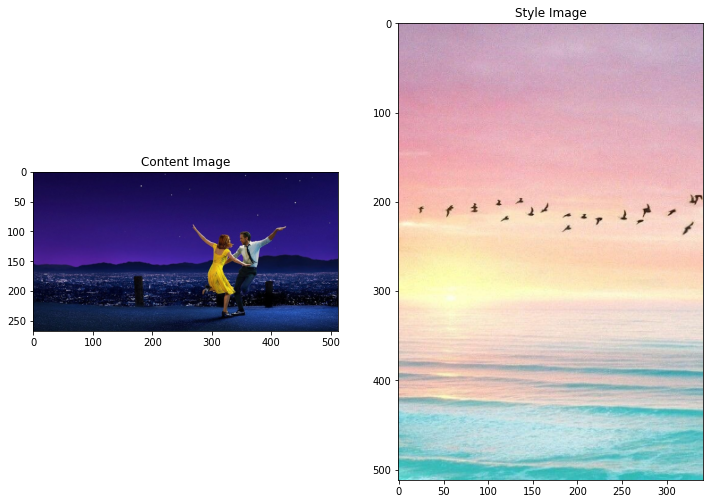

In [7]:
content_image=load_img(content_path)
style_image=load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image, 'Content Image')

plt.subplot(1,2,2)
imshow(style_image, 'Style Image')

# TF-Hub를 통한 빠른 스타일 전이
- 텐서플로우 허브 모듈

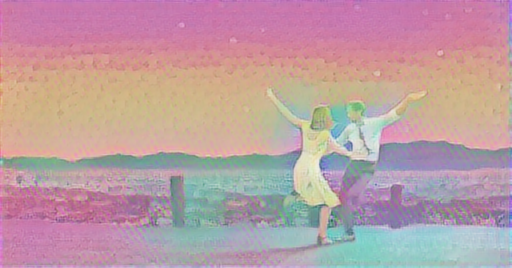

In [8]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [9]:
x=tf.keras.applications.vgg19.preprocess_input(content_image*255)
x=tf.image.resize(x,(224,224)) #vgg19의 이미지 크기는 224 * 224
vgg=tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities=vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 35s 0us/step


TensorShape([1, 1000])

vgg19 클래스
- include_top(True): 출력 레이어를 포함할 것인지 여부
- weights('imagenet'): 로딩할 가중치, 처음부터 훈련시키는데 관심이 있다면 None을 통해 사전에 훈련된 가중치를 사용하지 않아도 된다.
- input_tensor(None): 서로 다른 크기의 새로운 데이터에 모델을 맞추기 위한 새로운 입력 레이어, 입력 크기가 224*224가 아닐 때
- input_shape(None): 입력 레이어를 변경할 경우 모델이 가져올 것으로 기대하는 이미지 크기
- pooling(None): 출력 레이어의 새로운 세트를 훈련시킬 때 사용하는 풀링 타입
- classes(1000); 출력 벡터와 같은 해당 모델의 클래스의 수

In [10]:
predicted_top_5=tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('fountain', 0.21999237),
 ('torch', 0.08278658),
 ('lakeside', 0.060620602),
 ('unicycle', 0.048297137),
 ('seashore', 0.041676547)]

In [11]:
# Convolution 필터에 대해서만 관심이 있으면 False
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') 

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 5s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

print(num_content_layers, num_style_layers)

1 5


# 모델 만들기
- model=Model(inputs, outputs) ==> 모델의 입력과 출력 지정하여 모델 정의
- 아래의 함수는 ***중간층***들의 결과물을 배열 형태로 출력하는 VGG19 모델 반환


In [13]:
def vgg_layers(layer_names):
  vgg=tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable=False #이미지넷으로 학습된 값들을 그래도 사용할 것이기 때문에 파라미터 변동 X

  outputs=[vgg.get_layer(name).output for name in layer_names]

  model=tf.keras.Model([vgg.input], outputs)
  return model


In [14]:
style_extractor=vgg_layers(style_layers)
style_outputs=style_extractor(style_image*255)
print(style_extractor)
print(style_outputs)

# 각 층의 출력에 대한 통계량
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

[<tf.Tensor: shape=(1, 512, 341, 64), dtype=float32, numpy=
array([[[[0.00000000e+00, 3.68386841e+01, 2.11869278e+01, ...,
          0.00000000e+00, 4.47653847e+01, 0.00000000e+00],
         [0.00000000e+00, 6.34628830e+01, 9.50157547e+01, ...,
          0.00000000e+00, 2.94960571e+02, 2.22605103e+02],
         [0.00000000e+00, 6.45193558e+01, 9.62458191e+01, ...,
          0.00000000e+00, 2.95673676e+02, 2.24982880e+02],
         ...,
         [0.00000000e+00, 6.39215202e+01, 1.00685349e+02, ...,
          0.00000000e+00, 3.07527283e+02, 2.30837372e+02],
         [0.00000000e+00, 6.44211121e+01, 1.00004074e+02, ...,
          0.00000000e+00, 3.08294739e+02, 2.29300644e+02],
         [7.18649244e+00, 8.89878387e+01, 1.77711746e+02, ...,
          0.00000000e+00, 5.18687805e+02, 5.13394287e+02]],

        [[0.00000000e+00, 4.45456848e+01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.05916262e+01, 7.74505157e+01, 7.13060150e+01, ...,
       

In [15]:
# Gram matrix 구현
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [16]:
# Style과 Contents 추출
# 스타일과 콘텐츠 텐서를 반환하는 모델
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg=vgg_layers(style_layers+content_layers)
    self.style_layers=style_layers
    self.content_layers=content_layers
    self.num_style_layers=len(style_layers)
    self.vgg.trainable=False

  def call(self, inputs):
   # "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}



In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())


스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.013383052
    최댓값:  34271.977
    평균:  1102.7029

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  150898.69
    평균:  20507.104

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  585247.6
    평균:  16922.562

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  10020128.0
    평균:  277611.62

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  155511.66
    평균:  2056.5144

콘텐츠:
   block5_conv2
    크기:  (1, 16, 32, 512)
    최솟값:  0.0
    최댓값:  1679.0339
    평균:  15.2480545


In [18]:
# 경사하강법 실행
# 입력 이미지와 타킷에 대한 오차를 평균 제곱한 뒤, 오차값들의 가중합 구하기

style_targets=extractor(style_image)['style']
content_targets=extractor(content_image)['content']
image=tf.Variable(content_image)

# tf.Variable
- 모델을 훈련할 때 모델의 파라미터들을 저장할 변수
- Variable: 텐서를 메모리에 저장하는 변수이다.
- 명시적으로 초기화되어야 하고, 학습 뒤에 디스크에 저장하고 필요할 때 다시 불러올 수 있다.

In [36]:
#데이터 전처리: 픽셀 값을 0~1 사이로

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [37]:
# 옵티마이저 생성: Adam
opt=tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [38]:
#최적화: 전체 오차=콘테츠 오차+스타일 오차의 가중합
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
  style_outputs=outputs['style']
  content_outputs=outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return loss

In [39]:
#tf.GradientTape 이용해 이미지 업데이트
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

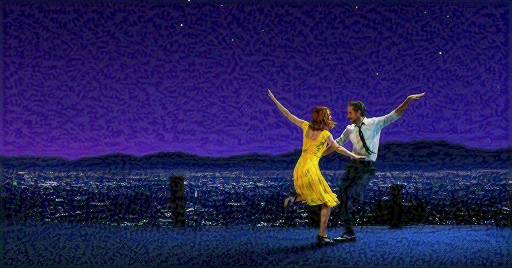

In [40]:
#알고리즘 시험
image=tf.Variable(content_image)
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

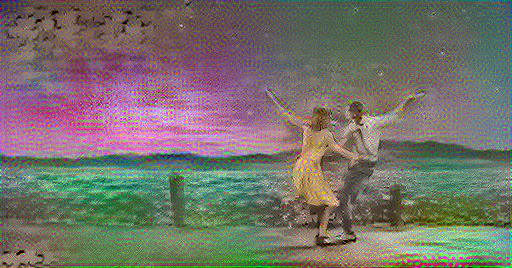

훈련 스텝: 0
전체 소요 시간: 4179.8


In [41]:
# 더 오랫동안 최적화 하기
import time
start=time.time()

epochs=10
steps_per_epoch=100
step=0

for n in range(epochs):
  for m in range(steps_per_epoch):
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

# 총 변위 손실
- 이 기본 구현 방식의 단점은 High-frequency artifact가 생겨난다는 점
- 이미지의 고주파 구성 요소에 대한 Regularization 항을 추가해야 한다.
- 이 변형된 오차값을 스타일 전이에서 총 변위 손실이라고 한다.

In [42]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

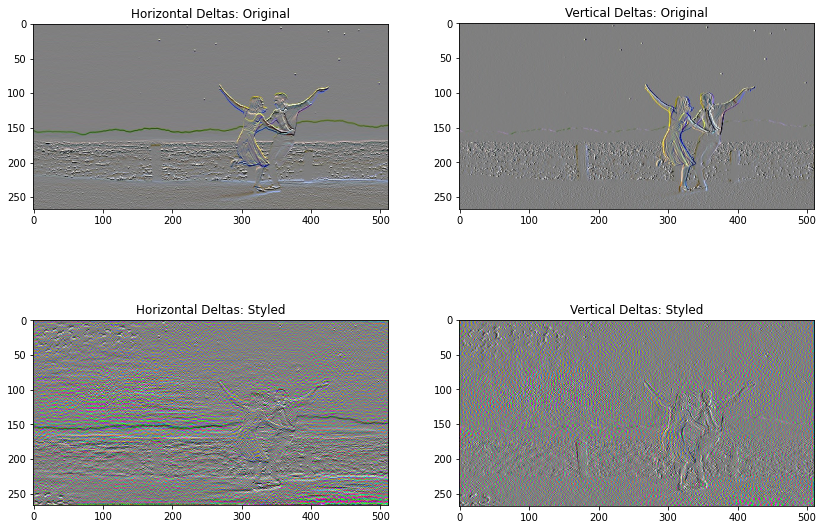

In [43]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")



In [44]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()

79481.37

In [45]:
tf.image.total_variation(image).numpy()

array([79481.37], dtype=float32)

In [49]:
#다시 최적화
total_variation_weight=30 # total_variation_loss를 위한 가중치

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

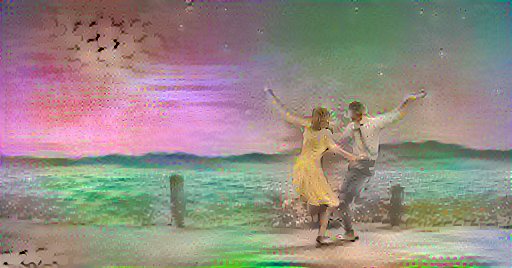

훈련 스텝: 1000
전체 소요 시간: 4237.8


In [50]:
image = tf.Variable(content_image)

import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))